In [57]:
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt
import intern
from intern.remote.boss import BossRemote
from PIL import Image
import os
from skimage import measure

In [58]:
#Define the Boss Remote with your API token
rmt = BossRemote({
    "protocol": "https",
    "host": "api.bossdb.org",
    "token": "9154f9b731940e65844ea3568a0d7daa94f06f8b",
})

#Define the data's location in the boss. 
COLL_NAME = 'OlfactoryBulbMicrogliaPlasticity'
EXP_NAME = 'PTSD'
CHAN_NAME = 'microgliaI'

# Grab the channel
chan = rmt.get_channel(CHAN_NAME, COLL_NAME, EXP_NAME)

x_rng = [350, 1400]
y_rng = [1200, 1800]
z_rng = [699, 700]
#Grab the cutout from BOSS
rawMicroGlia = rmt.get_cutout(chan, 0,x_rng, y_rng, z_rng,)
print("Data shape: " + str(rawMicroGlia.shape))

Data shape: (1, 600, 1050)


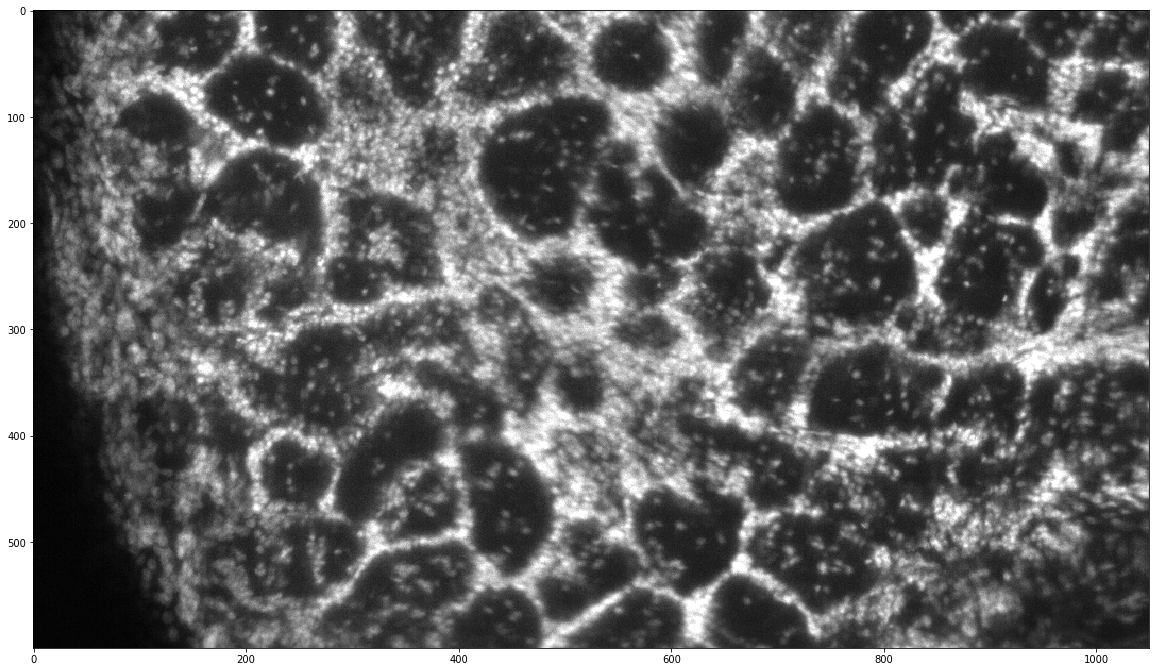

In [59]:
# Show for sanity check
plt.imshow(rawMicroGlia[0,:,:], cmap="gray")
plt.show()

In [60]:
#Evaluate using Otsu thresholding
val = filters.threshold_otsu(rawMicroGlia)
maskMicroGlia = rawMicroGlia < val

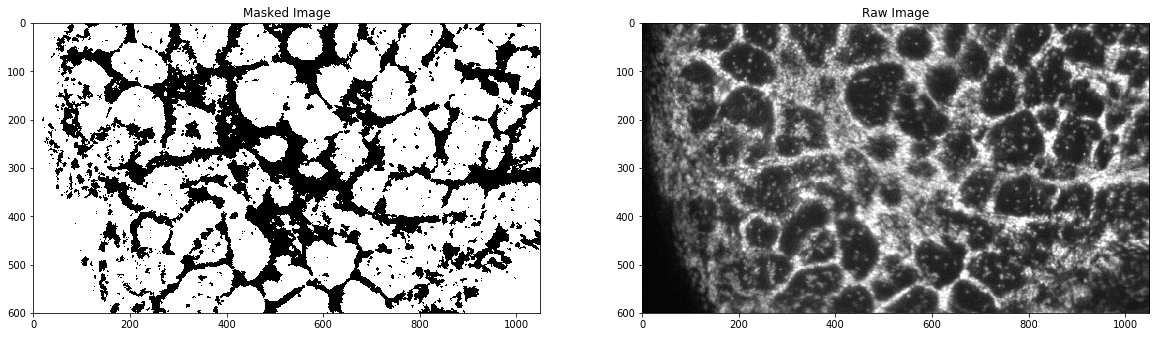

In [61]:
# Show for sanity check
f, axarr = plt.subplots(1,2)
plt.rcParams["figure.figsize"] = (10,10)
axarr[0].imshow(maskMicroGlia[0,:,:], cmap="gray")
axarr[1].imshow(rawMicroGlia[0,:,:], cmap="gray")
axarr[0].title.set_text('Masked Image')
axarr[1].title.set_text('Raw Image')
plt.show()

In [62]:
#Evaluate using mean thresholding
thresh = 100
print(thresh)
meanMicroGlia = rawMicroGlia < thresh

100


In [63]:
#Gaussian Method
n = 10
l = 256
sig = l / (4. * n)
print("Sigma value used is: " + str(sig))
gaussianMicroGlia = filters.gaussian(maskMicroGlia, sigma=sig)

Sigma value used is: 6.4


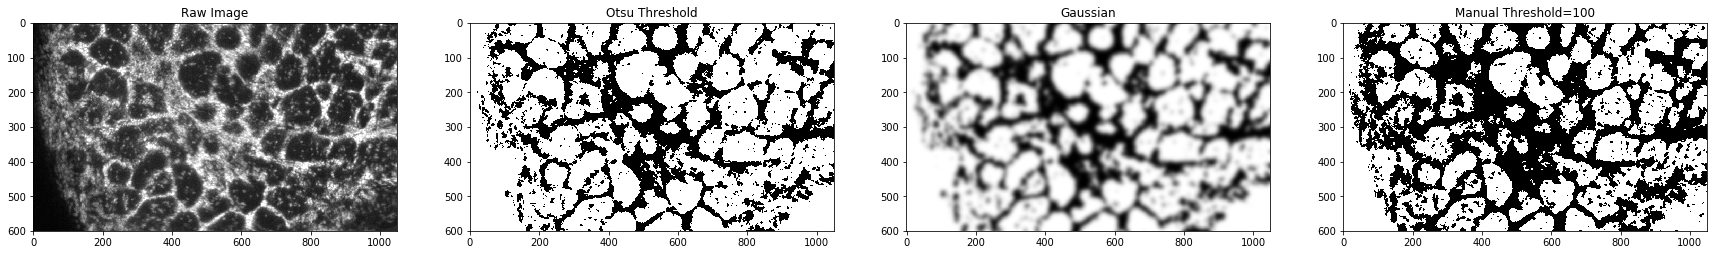

In [64]:
# Show for sanity check
plt.rcParams["figure.figsize"] = (30,30)
f, axarr = plt.subplots(1,4)
axarr[0].imshow(rawMicroGlia[0,:,:], cmap="gray")
axarr[1].imshow(maskMicroGlia[0,:,:], cmap="gray")
axarr[2].imshow(gaussianMicroGlia[0,:,:], cmap="gray")
axarr[3].imshow(meanMicroGlia[0,:,:], cmap="gray")
axarr[1].title.set_text('Otsu Threshold')
axarr[0].title.set_text('Raw Image')
axarr[2].title.set_text('Gaussian')
axarr[3].title.set_text('Manual Threshold=' + str(thresh))
plt.show()

In [65]:
blobs = meanMicroGlia > meanMicroGlia.mean()
all_labels = measure.label(blobs)
blobs_labels = measure.label(blobs, background=0)

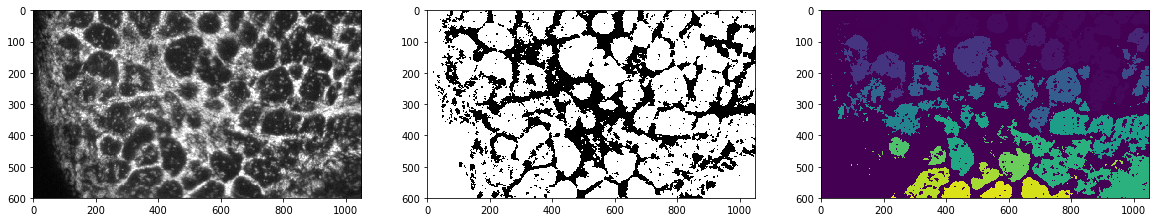

In [66]:
# Show for sanity check
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(rawMicroGlia[0,:,:], cmap="gray")
axarr[1].imshow(maskMicroGlia[0,:,:], cmap="gray")
axarr[2].imshow(blobs_labels[0,:,:])
plt.show()

In [67]:
comp = np.unique(blobs_labels)
print("There are " + str(len(comp)) + " microglia in this volume")

There are 654 microglia in this volume


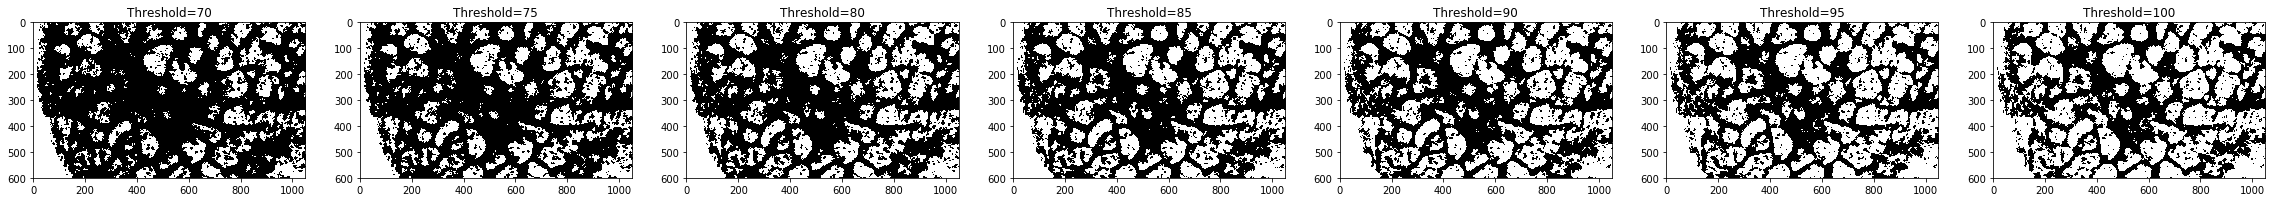

In [68]:
# Visualize different Threshold options
plt.rcParams["figure.figsize"] = (40,40)
i = 0
f, axarr = plt.subplots(1,7)
for thresh in range(70, 105, 5):
    manualThreshMicroGlia = rawMicroGlia < thresh 
    axarr[i].imshow(manualThreshMicroGlia[0,:,:], cmap="gray")
    axarr[i].title.set_text('Threshold=' + str(thresh))
    i+=1

Using threshold= 70 There are 1923 microglia in this volume
Using threshold= 75 There are 1430 microglia in this volume
Using threshold= 80 There are 1190 microglia in this volume
Using threshold= 85 There are 947 microglia in this volume
Using threshold= 90 There are 857 microglia in this volume
Using threshold= 95 There are 730 microglia in this volume
Using threshold= 100 There are 654 microglia in this volume


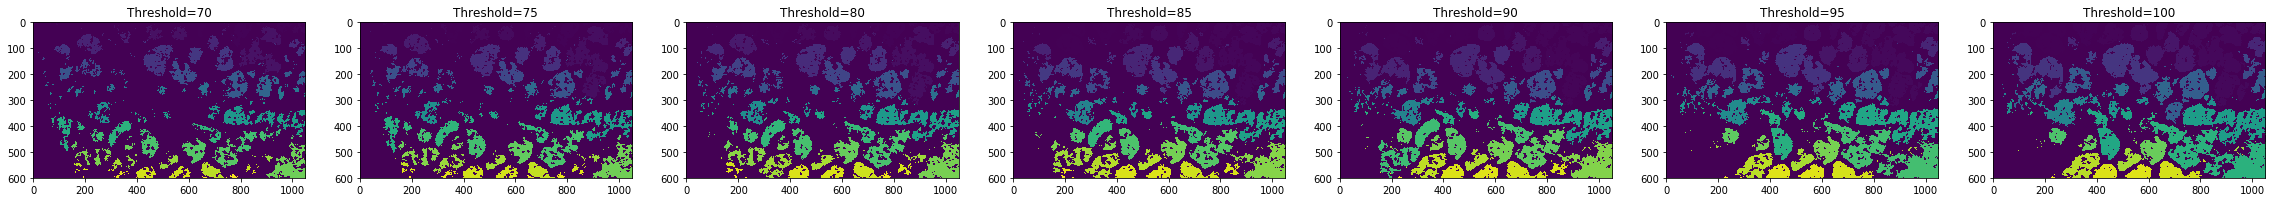

In [69]:
# Show the labeled blobs for each one of the thresholds defined above
i = 0 # Keeps track of plot position
maxMicroGlia = 0# Keeps track of max microglia count
f, axarr = plt.subplots(1,7) # Manual input of how many plots there will be considering the range and interval
                             # of thresholds being analyzed
for thresh in range(70, 105, 5):
    manualThreshMicroGlia = rawMicroGlia < thresh 
    blobs = manualThreshMicroGlia > manualThreshMicroGlia.mean()
    all_labels = measure.label(blobs)
    blobs_labels = measure.label(blobs, background=0)
    axarr[i].imshow(blobs_labels[0,:,:])
    axarr[i].title.set_text('Threshold=' + str(thresh))
    
    comp = np.unique(blobs_labels)
    print("Using threshold= " + str(thresh) + " There are "+ str(len(comp)) + " microglia in this volume")
    i+=1

#The code below would be an f1 score calculator. Which would allow us to keep the best threshold best on f1 score. 
#     if maxMicroGlia < len(comp):
#         print(maxMicroGlia)
#         print(len(comp))
#         maxMicroGlia = len(comp)
#         best_blob_labels = blobs_labels
#         best_thresh = thresh
# print("The best threshold is " + str(best_thresh))

In [76]:
"""
As of right now I am manually putting this is the best threshold
from what I can see by visually inspecting the image.
In the future this would be replaced by an f1 score calculation from a comparison with annotated data. 
"""
best_thresh = 90
manualThreshMicroGlia = rawMicroGlia < best_thresh 
blobs = manualThreshMicroGlia > manualThreshMicroGlia.mean()
all_labels = measure.label(blobs)
best_blobs_labels = measure.label(blobs, background=0)

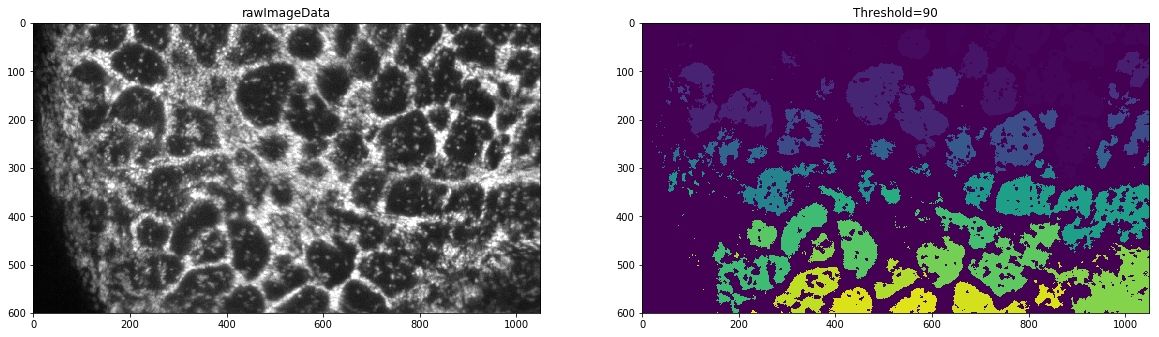

In [77]:
# Show the plot of the best labeled blobs
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(rawMicroGlia[0,:,:], cmap="gray")
axarr[0].title.set_text('rawImageData')
axarr[1].imshow(best_blobs_labels[0,:,:])
axarr[1].title.set_text('Threshold=' + str(best_thresh))

In [78]:
# Show the best number of microglia claculated. 
best_comp = np.unique(best_blobs_labels)
print("There are "+ str(len(best_comp)) + " microglia in this volume")

There are 857 microglia in this volume


In [79]:
## Upload the annotations to the BOSS
# Define the data's location in the boss. 
COLL_NAME = 'OlfactoryBulbMicrogliaPlasticity'
EXP_NAME = 'PTSD'
CHAN_NAME = 'microGliaPreAnnos '

# Grab the channel
ann_chan = rmt.get_channel(CHAN_NAME, COLL_NAME, EXP_NAME)

In [80]:
#Define variable data make sure it is in contiguous order and as uint 64 for annotation
data = best_blobs_labels
data = data.copy(order="C")
data = data.astype(np.uint64)

In [81]:
rmt.create_cutout(ann_chan, 0, x_rng, y_rng, z_rng, data)